In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch import nn,optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,TensorDataset

autoencoder sendiri hampir sama konsep nya dengan CNN dimana kalau di unsupervised learning biasa (PCA dan Dimensionality Reduction) kita tentukan sendiri mau jadi berapa feature nya dicompres untuk di training, tapi kalau auto encoder ini kita akan coba kasih ke mesin untuk memperlajari sendiri mau seberapa feature nya dicompres,  dan dibelakang layar sama menggunakan neural network dimana akan dikompres atau dikecilkan bagian hidden layers nya sampe misal 32 komponen dan untuk memastikan bahwa feature yang dikompres itu ""hanya kehilangan sedikit informasi"" kita coba buat hidden layers tambahan yang kita buat seperti hasil akhir nya sesuai input diawal.
* ide ini yang dibalik layar bisa men genarate diri sendiri sebagai output atau target nya walaupun beberapa feature telah dikompres tapi dengan ditraining weight nya tetap bisa genarate input nya lagi.

In [2]:
import torch

In [3]:
device = torch.device("cuda"if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset dan Dataloader

In [4]:
bs = 64
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])


trainset = datasets.ImageFolder("data/train/",transform=transform)
train_loader = DataLoader(trainset, bs,shuffle=True,num_workers=4)
testset =datasets.ImageFolder("data/test/",transform=transform)
test_loader = DataLoader(testset,bs,shuffle=True)

In [9]:
feature,target = next(iter(train_loader))
feature,target

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [10]:
feature.shape[0]

64

# Arsitektur dan Config

In [5]:
from jcopdl.layers import linear_block

In [6]:
class AutoEncoder (nn.Module):
    def __init__ (self, z_size):
        super().__init__()
        
        self.encode = nn.Sequential(
            linear_block(784,512,batch_norm=True),
            linear_block(512,256,batch_norm=True),
            linear_block(256,z_size,activation="sigmoid")
        )
        self.decode = nn.Sequential(
            linear_block(z_size,256,batch_norm=True),
            linear_block(256,512,batch_norm=True),
            linear_block(512,784,activation="sigmoid")
        )
        
        
    def forward (self, x):
        x= self.encode(x)
        x= self.decode(x)
        return x

In [7]:
from jcopdl.callback import Callback,set_config

In [8]:
config = set_config({
    "z_size": 32,
    "batch_size": bs
})

# Training Preparation ~> MCOC

In [9]:
model = AutoEncoder(config.z_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(),lr = 0.001)
callback = Callback(model,config=config,outdir="model/auto_encoder")

# Training Loop
### feature nya sendiri adalah target

In [10]:
from tqdm.auto import tqdm

In [11]:
def loop_fn (mode,dataset,dataloader,model,criterion,optimizer,device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, _ in tqdm(dataloader,desc=mode.title()):
        feature = feature.view(-1,784).to(device)
        output = model (feature)
        loss = criterion(output, feature)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        cost += loss.item()*feature.shape[0]
    cost = cost/len(dataset)
    return cost



Epoch     1
Train_cost  = 0.3334 | Test_cost  = 0.2542 | 




Epoch     2
Train_cost  = 0.1838 | Test_cost  = 0.1741 | 




Epoch     3
Train_cost  = 0.1597 | Test_cost  = 0.1524 | 




Epoch     4
Train_cost  = 0.1464 | Test_cost  = 0.1420 | 




Epoch     5
Train_cost  = 0.1355 | Test_cost  = 0.1334 | 




Epoch     6
Train_cost  = 0.1284 | Test_cost  = 0.1276 | 




Epoch     7
Train_cost  = 0.1226 | Test_cost  = 0.1237 | 




Epoch     8
Train_cost  = 0.1178 | Test_cost  = 0.1194 | 




Epoch     9
Train_cost  = 0.1134 | Test_cost  = 0.1162 | 




Epoch    10
Train_cost  = 0.1103 | Test_cost  = 0.1138 | 




Epoch    11
Train_cost  = 0.1075 | Test_cost  = 0.1120 | 




Epoch    12
Train_cost  = 0.1048 | Test_cost  = 0.1108 | 




Epoch    13
Train_cost  = 0.1026 | Test_cost  = 0.1092 | 




Epoch    14
Train_cost  = 0.1004 | Test_cost  = 0.1088 | 




Epoch    15
Train_cost  = 0.0994 | Test_cost  = 0.1064 | 




Epoch    16
Train_cost  = 0.0976 | Test_cost  = 0.1063 | 




Epoch    17
Train_cost  = 0.0962 | Test_cost  = 0.1045 | 




Epoch    18
Train_cost  = 0.0945 | Test_cost  = 0.1045 | 




Epoch    19
Train_cost  = 0.0931 | Test_cost  = 0.1032 | 




Epoch    20
Train_cost  = 0.0923 | Test_cost  = 0.1031 | 


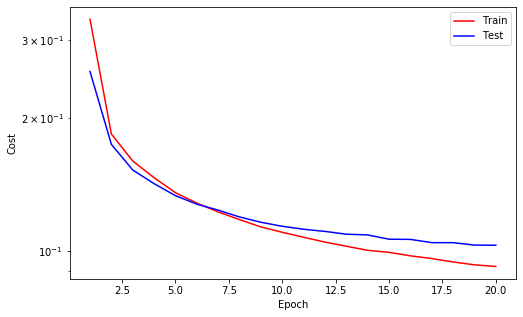



Epoch    21
Train_cost  = 0.0912 | Test_cost  = 0.1027 | 




Epoch    22
Train_cost  = 0.0902 | Test_cost  = 0.1023 | 




Epoch    23
Train_cost  = 0.0897 | Test_cost  = 0.1015 | 




Epoch    24
Train_cost  = 0.0888 | Test_cost  = 0.1018 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1015




Epoch    25
Train_cost  = 0.0882 | Test_cost  = 0.1013 | 




Epoch    26
Train_cost  = 0.0874 | Test_cost  = 0.1005 | 




Epoch    27
Train_cost  = 0.0866 | Test_cost  = 0.1000 | 




Epoch    28
Train_cost  = 0.0859 | Test_cost  = 0.1005 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1000




Epoch    29
Train_cost  = 0.0854 | Test_cost  = 0.0998 | 




Epoch    30
Train_cost  = 0.0845 | Test_cost  = 0.0997 | 




Epoch    31
Train_cost  = 0.0850 | Test_cost  = 0.0993 | 




Epoch    32
Train_cost  = 0.0842 | Test_cost  = 0.0995 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0993




Epoch    33
Train_cost  = 0.0837 | Test_cost  = 0.0988 | 




Epoch    34
Train_cost  = 0.0829 | Test_cost  = 0.0998 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0988




Epoch    35
Train_cost  = 0.0821 | Test_cost  = 0.0985 | 




Epoch    36
Train_cost  = 0.0822 | Test_cost  = 0.0987 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0985




Epoch    37
Train_cost  = 0.0822 | Test_cost  = 0.0993 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0985




Epoch    38
Train_cost  = 0.0818 | Test_cost  = 0.0989 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0985




Epoch    39
Train_cost  = 0.0814 | Test_cost  = 0.0997 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0985




Epoch    40
Train_cost  = 0.0812 | Test_cost  = 0.0984 | 


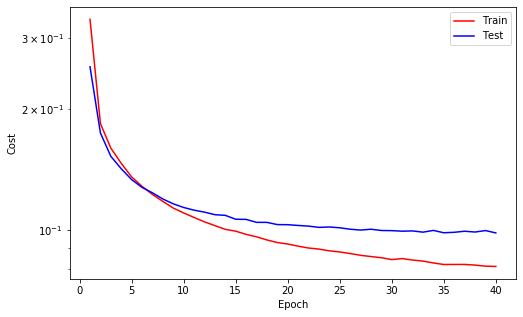



Epoch    41
Train_cost  = 0.0803 | Test_cost  = 0.0979 | 




Epoch    42
Train_cost  = 0.0804 | Test_cost  = 0.0983 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0979




Epoch    43
Train_cost  = 0.0802 | Test_cost  = 0.0980 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0979




Epoch    44
Train_cost  = 0.0796 | Test_cost  = 0.0978 | 




Epoch    45
Train_cost  = 0.0794 | Test_cost  = 0.0981 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0978




Epoch    46
Train_cost  = 0.0785 | Test_cost  = 0.0978 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0978




Epoch    47
Train_cost  = 0.0784 | Test_cost  = 0.0985 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0978




Epoch    48
Train_cost  = 0.0783 | Test_cost  = 0.0977 | 




Epoch    49
Train_cost  = 0.0784 | Test_cost  = 0.0984 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0977




Epoch    50
Train_cost  = 0.0779 | Test_cost  = 0.0978 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0977




Epoch    51
Train_cost  = 0.0774 | Test_cost  = 0.0979 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0977




Epoch    52
Train_cost  = 0.0775 | Test_cost  = 0.0977 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0977




Epoch    53
Train_cost  = 0.0776 | Test_cost  = 0.0975 | 




Epoch    54
Train_cost  = 0.0772 | Test_cost  = 0.0976 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0975




Epoch    55
Train_cost  = 0.0768 | Test_cost  = 0.0976 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0975




Epoch    56
Train_cost  = 0.0764 | Test_cost  = 0.0977 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0975




Epoch    57
Train_cost  = 0.0766 | Test_cost  = 0.0978 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0975




Epoch    58
Train_cost  = 0.0768 | Test_cost  = 0.0982 | 
==> EarlyStop patience =  5 | Best test_cost: 0.0975
==> Execute Early Stopping at epoch: 58 | Best test_cost: 0.0975
==> Best model is saved at model/auto_encoder


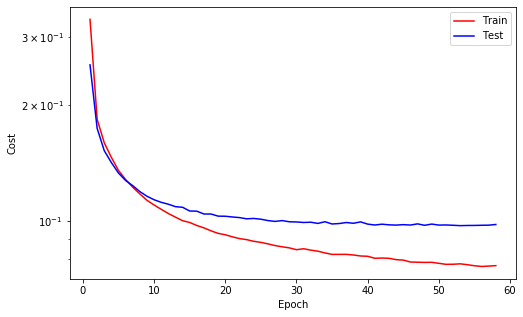

In [12]:
while True : 
    train_cost= loop_fn("train",trainset,train_loader,model,criterion,optimizer,device)
    with torch.no_grad():
        test_cost = loop_fn("test",testset,test_loader,model,criterion,optimizer,device)
    
    # Logging and Reporting
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
   
    
    # Early Stopping
    if callback.early_stopping(model, monitor='test_cost'):
        callback.plot_cost()
      
        break

# saniti check
* coba kita lihat dari feature yang belum di kompres
* coba lihat feature yang dikompres (encode)
* coba lihat feature yang telah dikompres lalu di generate ulang (decode)

In [13]:
feature, target = next(iter(test_loader))
feature= feature.view(-1,784).to(device)

lalu coba masukin data test ke feed forward atau di test

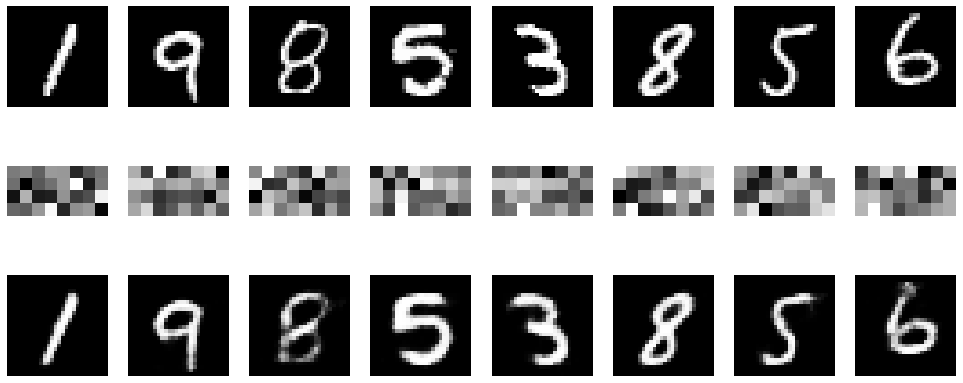

In [14]:
with torch.no_grad():
    model.eval()
    enc= model.encode(feature)
    dec= model.decode(enc)
fig, ax = plt.subplots(3,8,figsize = (17,7))
for i in range(8):
    ax[0,i].imshow(feature[i].view(28,28).cpu(), cmap="gray")
    ax[0,i].axis("off")
    
    ax[1,i].imshow(enc[i].view(4,8).cpu(), cmap="gray")
    ax[1,i].axis("off")
    
    ax[2,i].imshow(dec[i].view(28,28).cpu(), cmap="gray")
    ax[2,i].axis("off")
    

disini terlihat bahwa model berhasil generate diri nya sendiri(karna disini kita tidak menggunakan informasi target) walaupun sudah di kompres menjadi 32 feature dari 784, disini model mengambil feature yang penting penting saja yang mewakili semua data (terlihat dari gambar angka 8 yang berlebih setelah di generate, feature yang berlebih itu akan dibuang karna itu informasi yang spesifik dan tidak mewakili semua informasi data.

# Denoising Auto Encoder
* mencoba membuat model yang bisa menghapus noise pada input kita, dengan memanfaatkan ide dimensionality reduction (menghilangkan beberapa feature yang dianggap gak penting) menghasilkan sesuatu feature yang bersih dari noise.
* input kita dikasih noise, lalu coba kita kasih model kita untuk memperlajari feature dari input yang bersih dari noise, guna membangun model yang bisa menghilangkan noise pada suatu target model.

##### pertama kita buat dulu fungsi untuk menambahkan noise pada input

In [15]:
def noise (images, noise_factor = 0.5):
    images = torch.clone(images)
    images+= noise_factor * torch.rand_like(images)
    images = images.clamp(0. , 1.)
    return images

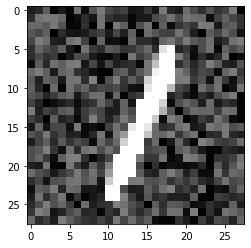

In [16]:
plt.imshow(noise(feature[0]).view(28,28).cpu(), cmap="gray")

# Training Preparation ~> MCOC

In [20]:
model = AutoEncoder(config.z_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(),lr = 0.001)
callback = Callback(model,config=config,outdir="model/auto_encoder")

# Training Loop
### input nya ditambah noise, target nya tetap yang bersih

In [21]:
from tqdm.auto import tqdm

In [22]:
def loop_fn (mode,dataset,dataloader,model,criterion,optimizer,device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, _ in tqdm(dataloader,desc=mode.title()):
        feature = feature.view(-1,784).to(device)
        output = model (noise(feature))
        loss = criterion(output, feature)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        cost += loss.item()*feature.shape[0]
    cost = cost/len(dataset)
    return cost



Epoch     1
Train_cost  = 0.3377 | Test_cost  = 0.2621 | 




Epoch     2
Train_cost  = 0.1872 | Test_cost  = 0.1773 | 




Epoch     3
Train_cost  = 0.1635 | Test_cost  = 0.1575 | 




Epoch     4
Train_cost  = 0.1501 | Test_cost  = 0.1472 | 




Epoch     5
Train_cost  = 0.1401 | Test_cost  = 0.1383 | 




Epoch     6
Train_cost  = 0.1330 | Test_cost  = 0.1334 | 




Epoch     7
Train_cost  = 0.1275 | Test_cost  = 0.1279 | 




Epoch     8
Train_cost  = 0.1229 | Test_cost  = 0.1253 | 




Epoch     9
Train_cost  = 0.1191 | Test_cost  = 0.1222 | 




Epoch    10
Train_cost  = 0.1160 | Test_cost  = 0.1203 | 




Epoch    11
Train_cost  = 0.1136 | Test_cost  = 0.1186 | 




Epoch    12
Train_cost  = 0.1105 | Test_cost  = 0.1168 | 




Epoch    13
Train_cost  = 0.1089 | Test_cost  = 0.1157 | 




Epoch    14
Train_cost  = 0.1072 | Test_cost  = 0.1142 | 




Epoch    15
Train_cost  = 0.1056 | Test_cost  = 0.1134 | 




Epoch    16
Train_cost  = 0.1039 | Test_cost  = 0.1125 | 




Epoch    17
Train_cost  = 0.1026 | Test_cost  = 0.1110 | 




Epoch    18
Train_cost  = 0.1008 | Test_cost  = 0.1120 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1110




Epoch    19
Train_cost  = 0.1006 | Test_cost  = 0.1107 | 




Epoch    20
Train_cost  = 0.0993 | Test_cost  = 0.1098 | 


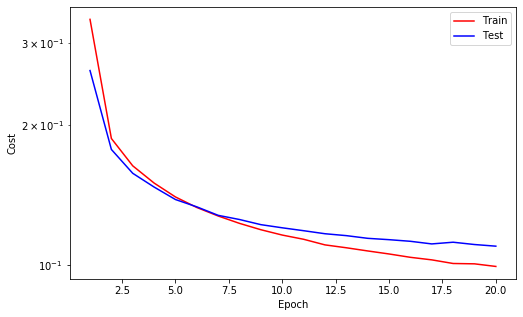



Epoch    21
Train_cost  = 0.0989 | Test_cost  = 0.1092 | 




Epoch    22
Train_cost  = 0.0981 | Test_cost  = 0.1085 | 




Epoch    23
Train_cost  = 0.0957 | Test_cost  = 0.1083 | 




Epoch    24
Train_cost  = 0.0949 | Test_cost  = 0.1073 | 




Epoch    25
Train_cost  = 0.0950 | Test_cost  = 0.1070 | 




Epoch    26
Train_cost  = 0.0945 | Test_cost  = 0.1089 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1070




Epoch    27
Train_cost  = 0.0933 | Test_cost  = 0.1073 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1070




Epoch    28
Train_cost  = 0.0933 | Test_cost  = 0.1067 | 




Epoch    29
Train_cost  = 0.0925 | Test_cost  = 0.1065 | 




Epoch    30
Train_cost  = 0.0921 | Test_cost  = 0.1065 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1065




Epoch    31
Train_cost  = 0.0905 | Test_cost  = 0.1048 | 




Epoch    32
Train_cost  = 0.0903 | Test_cost  = 0.1057 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1048




Epoch    33
Train_cost  = 0.0898 | Test_cost  = 0.1058 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1048




Epoch    34
Train_cost  = 0.0900 | Test_cost  = 0.1053 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1048




Epoch    35
Train_cost  = 0.0896 | Test_cost  = 0.1050 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1048




Epoch    36
Train_cost  = 0.0887 | Test_cost  = 0.1049 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1048
==> Execute Early Stopping at epoch: 36 | Best test_cost: 0.1048
==> Best model is saved at model/auto_encoder


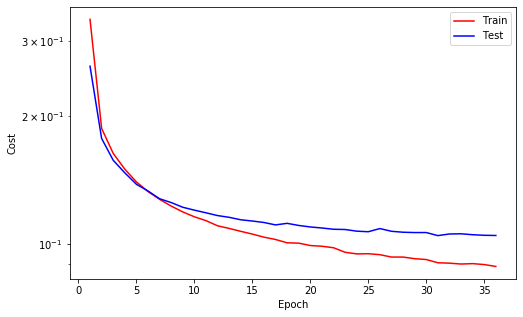

In [23]:
while True : 
    train_cost= loop_fn("train",trainset,train_loader,model,criterion,optimizer,device)
    with torch.no_grad():
        test_cost = loop_fn("test",testset,test_loader,model,criterion,optimizer,device)
    
    # Logging and Reporting
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
   
    
    # Early Stopping
    if callback.early_stopping(model, monitor='test_cost'):
        callback.plot_cost()
      
        break

# saniti check
* coba kita lihat dari feature yang belum di kompres
* coba lihat feature yang dikompres (encode)
* coba lihat feature yang telah dikompres lalu di generate ulang (decode)

In [26]:
feature, target = next(iter(test_loader))
feature= noise(feature).view(-1,784).to(device)

lalu coba masukin data test ke feed forward atau di test

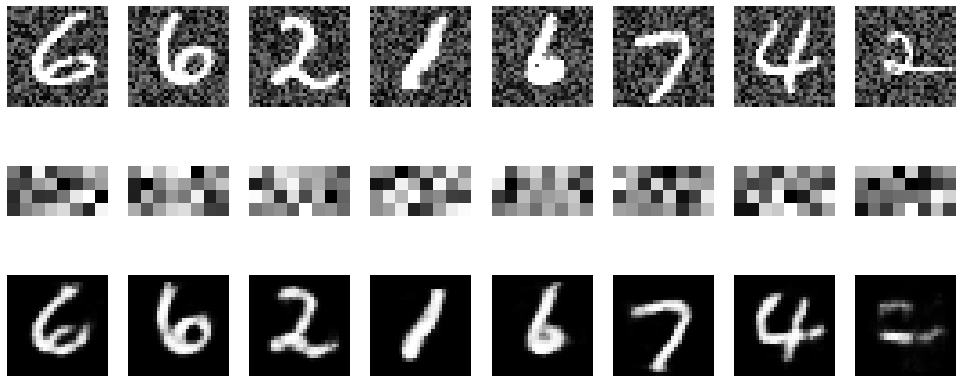

In [27]:
with torch.no_grad():
    model.eval()
    enc= model.encode(feature)
    dec= model.decode(enc)
fig, ax = plt.subplots(3,8,figsize = (17,7))
for i in range(8):
    ax[0,i].imshow(feature[i].view(28,28).cpu(), cmap="gray")
    ax[0,i].axis("off")
    
    ax[1,i].imshow(enc[i].view(4,8).cpu(), cmap="gray")
    ax[1,i].axis("off")
    
    ax[2,i].imshow(dec[i].view(28,28).cpu(), cmap="gray")
    ax[2,i].axis("off")
    